# GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/Slimn/anaconda3/envs/tfdl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/Slimn/anaconda3/envs/tfdl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/Users/Slimn/anaconda3/envs/tfdl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/Slimn/anaconda3/envs/tfdl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## The Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

/Users/Slimn/anaconda3/envs/tfdl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/Slimn/anaconda3/envs/tfdl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/Slimn/anaconda3/envs/tfdl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
mnist = input_data.read_data_sets("../../data/MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


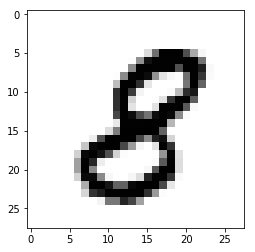

In [7]:
plt.imshow(mnist.train.images[5].reshape(28,28), cmap='Greys')

## The Networks
Useful Links:

https://stackoverflow.com/questions/45307072/using-leaky-relu-in-tensorflow

### The Generator

In [9]:
def generator(z, reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z, units=128, activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(inputs=hidden1, units=128, activation=tf.nn.leaky_relu)
        
        output = tf.layers.dense(inputs=hidden2, units=784, activation=tf.nn.tanh)
        return output

In [13]:
def discriminator(X, reuse=None):
    with tf.variable_scope('dis', reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X, units=128, activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(inputs=hidden1, units=128, activation=tf.nn.leaky_relu)
        
        logist = tf.layers.dense(inputs=hidden2, units=1)
        output = tf.sigmoid(logist)
        return output, logist
        

### Placeholders

In [11]:
real_images = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100])

### Generator

In [12]:
G = generator(z)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


### Discriminator 

In [14]:
D_output_real, D_logist_real = discriminator(real_images)

In [15]:
D_output_fake, D_logist_fake = discriminator(G, reuse=True)

### Losses

In [16]:
def loss_func(logits, label_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=label_in))

In [17]:
smooth_factor = 0.9
D_real_loss = loss_func(D_logist_real, tf.ones_like(D_logist_real) * smooth_factor)

In [19]:
D_fake_loss = loss_func(D_logist_fake, tf.zeros_like(D_logist_real))

In [20]:
D_loss = D_real_loss + D_fake_loss

In [21]:
G_loss = loss_func(D_logist_fake, tf.ones_like(D_logist_fake))

### Optimizers

In [22]:
learning_rate = 0.001

In [23]:
tvars = tf.trainable_variables()

In [24]:
d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [34]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Training Session

In [35]:
batch_size = 100
epochs = 30

In [36]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [39]:
# Save sample per epoch
samples = []

In [40]:
with tf.Session() as sess:
    
    sess.run(init)
    
    # Recall an epoch is an entire run through the training data
    for e in range(epochs):
        # // indicates classic division
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            # Grab batch of images
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            # Run optimizers, no need to save outputs, we won't use them
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})
        
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample)
        saver.save(sess, '../../models/gan_ex_model.ckpt')

Currently on Epoch 1 of 30 total...
Currently on Epoch 2 of 30 total...
Currently on Epoch 3 of 30 total...
Currently on Epoch 4 of 30 total...
Currently on Epoch 5 of 30 total...
Currently on Epoch 6 of 30 total...
Currently on Epoch 7 of 30 total...
Currently on Epoch 8 of 30 total...
Currently on Epoch 9 of 30 total...


KeyboardInterrupt: 

In [41]:
saver = tf.train.Saver(var_list=g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'../../models/500_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../models/500_epoch_model.ckpt


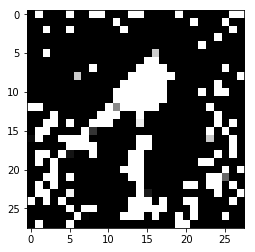

In [42]:
plt.imshow(new_samples[0].reshape(28,28),cmap='Greys')